# <center> Data Cleaning & NLP Pipeline for Social Media Opinions on Food Security in Malaysia 🌍 <br> (VADER Sentiment, LDA Topic Modeling & Risk Detection) </center>


## 📚 Notebook Overview

This notebook is designed for preparing and cleaning a dataset on social media opinions regarding food security in Malaysia. The overall workflow involves multiple steps, combining natural language processing, sentiment analysis, topic modeling, and spatiotemporal analysis to extract actionable insights.

#### 🔑 Steps:
1. **Data Translation** : Since the dataset contains posts in multiple languages, the first step is to translate all text data into English using Google Translate API.
2. **Data Cleaning & Preprocessing** : Apply standard text cleaning procedures including expanding contractions, removing URLs, mentions, emojis, special characters, and stopwords. Additionally, perform lemmatization to normalize words and reduce dimensionality.
3. **Sentiment Scoring** : Use VADER (Valence Aware Dictionary and sEntiment Reasoner) for sentiment scoring.
4. **Risk detection** : Identify high-risk or vulnerable tweets by setting sentiment score thresholds. Tweets expressing strong negative sentiments related to food insecurity are flagged for further attention.
5. **Topic modeling** : Use Latent Dirichlet Allocation (LDA) to discover key themes and discussion topics related to food security.
6. **Geospacial and temporal analysis** :
    * Visualize food security risk levels by location
    * Analyze the average risk level and topic distribution monthly over time to observe trends and changes


## 🛠️ Step 1: Install Required Packages


In [ ]:
#pip install polyglot
#pip install pyicu
#pip install pycld2
#pip install morfessor
#pip install contractions
#pip install googletrans
#pip install gensim
#pip install pyLDAvis

## 📚 Step 2: Import Necessary Libraries

In [51]:
import numpy as np
import pandas as pd
import re
import nltk
import contractions
import asyncio
import nest_asyncio
from tqdm.asyncio import tqdm_asyncio
import time
from googletrans import Translator
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import joblib

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from polyglot.detect import Detector
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Initialize lemmatizer, Stemmer and stopwords
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# English stopwords
stop_words_en = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 🔍 Step 3: Load and Explore the Dataset

In [10]:
path = '/kaggle/input/sentiment-analysis-for-food-insecurity/food_security_tweets_malaysia.csv'
data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75336 entries, 0 to 75335
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  75336 non-null  object 
 1   ID        75336 non-null  float64
 2   Username  75336 non-null  object 
 3   Text      75336 non-null  object 
 4   Location  60755 non-null  object 
dtypes: float64(1), object(4)
memory usage: 2.9+ MB


In [11]:
data.head(10)

,Datetime,ID,Username,Text,Location
0,2022-02-01 00:18:19+00:00,1.490000e+18,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru
1,2022-02-01 00:20:14+00:00,1.490000e+18,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",NaN
2,2022-02-01 01:04:00+00:00,1.490000e+18,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia
3,2022-02-01 01:06:14+00:00,1.490000e+18,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia"
4,2022-02-01 01:20:36+00:00,1.490000e+18,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur
5,2022-02-01 01:20:36+00:00,1.488320e+18,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur
6,2022-02-01 01:32:54+00:00,1.490000e+18,RazakZaha,@ar_zaini3339 Slow tu.. Selalu masalah lapar t...,Kuala Lumpur
7,2022-02-01 02:54:44+00:00,1.490000e+18,teekayzamri,Lalalala lapar nasi (@ Restoran Sambal Hijau i...,Kuala Lumpur
8,2022-02-01 03:33:33+00:00,1.488350e+18,KhaosodEnglish,(2/3) Suwanna said many fear the spill’s arriv...,"Bangkok, Thailand"
9,2022-02-01 03:56:07+00:00,1.490000e+18,StephaninBKK,@hizaga @703pippa Yes! When I go shopping hun...,Bangkok


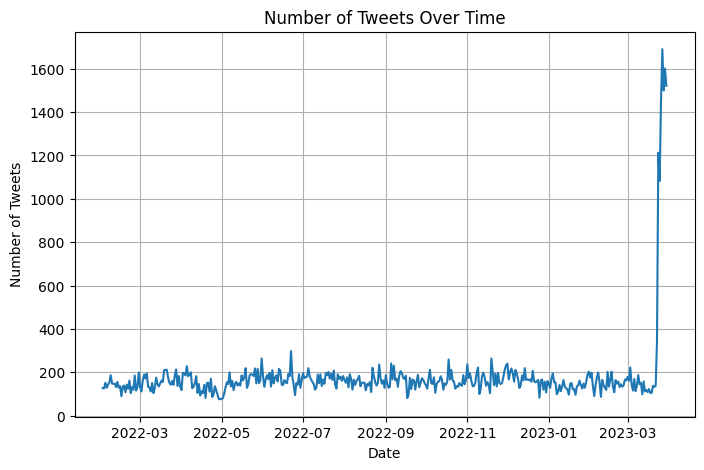

In [12]:
# Convert if not already
datetime = pd.DataFrame()
datetime['Datetime'] = pd.to_datetime(data['Datetime'])

# Group by date only (without time) and count tweets per day
datetime['Date'] = datetime['Datetime'].dt.date
tweet_counts = datetime.groupby('Date').size()

plt.figure(figsize=(8, 5))
tweet_counts.plot()

plt.title('Number of Tweets Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.grid(True)
plt.show()

In [13]:
data = data.drop(['ID'], axis=1)

In [14]:
data = data.drop_duplicates(['Text'] , keep='first')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34103 entries, 0 to 75309
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Datetime  34103 non-null  object
 1   Username  34103 non-null  object
 2   Text      34103 non-null  object
 3   Location  28248 non-null  object
dtypes: object(4)
memory usage: 1.3+ MB


In [15]:
def detect_language(text):
    try:
        return Detector(text).language.code
    except:
        return None

languages = pd.DataFrame()      
languages['Code'] = data['Text'].apply(detect_language)

In [16]:
language_counts = languages['Code'].value_counts()
print(language_counts)

Code
en    13124
ms    10225
id     8983
su      274
tl      265
      ...  
ko        1
sw        1
ia        1
eo        1
rn        1
Name: count, Length: 107, dtype: int64


## 🌐 Step 4: Translate Data to English


Since the dataset contains multiple languages, we will use **Google Translate** to convert all text into **English** to ensure consistency and ease of analysis. 

We'll be using the `googletrans` package to perform the translations.

In [17]:
async def translate_text(text):
    async with Translator() as translator:
        result = await translator.translate(text, dest='en')
        return result.text      
    
# Directly calling the async function without asyncio.run() in a Jupyter environment
await translate_text('يا الله i am hungry')

'Oh God I am hungry'

In [18]:
# Allow asyncio to run in notebook
nest_asyncio.apply()

semaphore = asyncio.Semaphore(15)  # Limit concurrency to avoid rate limiting

async def translate_text(text, retries=3):
    async with semaphore:
        for attempt in range(retries):
            try:
                async with Translator() as translator:
                    result = await translator.translate(text, dest='en')
                    return result.text
            except Exception as e:
                await asyncio.sleep(1 + attempt * 2)  # Backoff
                if attempt == retries - 1:
                    return f"ERROR: {str(e)}"

async def translate_column(text_list):
    return await tqdm_asyncio.gather(*(translate_text(text) for text in text_list))

start = time.time()
data['translated_Text'] = await translate_column(data['Text'].tolist())
end  = time.time()
print(f"Translation completed in {(end - start)/60:.2f} minutes")

100%|██████████| 34103/34103 [47:20<00:00, 12.01it/s]  

Translation completed in 47.34 minutes


In [20]:
data.head(15)

,Datetime,Username,Text,Location,translated_Text
0,2022-02-01 00:18:19+00:00,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t..."
1,2022-02-01 00:20:14+00:00,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",NaN,"One morning blind in Siantar,\n\n🗣: I'm hungry..."
2,2022-02-01 01:04:00+00:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...
3,2022-02-01 01:06:14+00:00,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...
4,2022-02-01 01:20:36+00:00,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...
6,2022-02-01 01:32:54+00:00,RazakZaha,@ar_zaini3339 Slow tu.. Selalu masalah lapar t...,Kuala Lumpur,@ar_zaini3339 slow tu ... always a hunger prob...
7,2022-02-01 02:54:44+00:00,teekayzamri,Lalalala lapar nasi (@ Restoran Sambal Hijau i...,Kuala Lumpur,Lalalala Hungry Rice (@ Green Sambal Restauran...
8,2022-02-01 03:33:33+00:00,KhaosodEnglish,(2/3) Suwanna said many fear the spill’s arriv...,"Bangkok, Thailand",(2/3) Suwanna said many fear the spill’s arriv...
9,2022-02-01 03:56:07+00:00,StephaninBKK,@hizaga @703pippa Yes! When I go shopping hun...,Bangkok,@hizaga @703pippa Yes! When I go shopping hun...
11,2022-02-01 04:11:09+00:00,cikgu_fadzli,"29 Januari 2022\nPasir Mas, Kelantan.\n\nMisi ...","Besut, Terengganu","January 29, 2022\nPasir Mas, Kelantan.\n\nThe ..."


## 🧹 Step 5: Data Cleaning & Preprocessing

The next step is to clean the data and prepare it for sentiment analysis. We'll perform the following tasks:
- **Expanding contractions** For example, converting "don't" to "do not", "I'm" to "I am", which helps with better tokenization and interpretation.
- **Remove unnecessary characters** (e.g., URLs, special symbols, emojis).
- **Convert text to lowercase** to maintain uniformity.
- **Remove stop words** Commonly used words such as “the”, “is”, “and” that do not add much semantic value are removed to focus on the key meaningful words.
- **Lemmatization**: Unlike stemming, lemmatization reduces words to their dictionary root form based on context and meaning (e.g., "better" → "good", "running" → "run"). It considers the context and the word’s role in a sentence.  It’s more accurate because it always returns a valid word and considers the word's meaning.


> **⚙️ Using a Preprocessing Pipeline :**
>
> To make the preprocessing process modular, reusable, and production-ready, we encapsulate all these steps in a Scikit-learn Pipeline.The same cleaning process can be reused later (e.g., during model inference or deployment) without rewriting code.


In [21]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def expand_contractions(self, text):
        return contractions.fix(text)

    def preprocess_text(self, text):
        text = self.expand_contractions(text)
        text = text.lower()
        text = re.sub(r'http\S+|www\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'([^\w\s])', r' \1 ', text)
        text = re.sub(r'[^\w\s]', '', text)

        tokens = word_tokenize(text)
        clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words_en and word.isalpha()]
        return ' '.join(clean_tokens)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, str):
            return self.preprocess_text(X)
        elif isinstance(X, pd.Series):
            return X.apply(self.preprocess_text)
        elif isinstance(X, list):
            return [self.preprocess_text(text) for text in X]
        else:
            raise TypeError("Input must be a string, list of strings, or pandas Series")

In [22]:
pipeline = Pipeline([
    ('text_preprocessor', TextPreprocessor())
])

# Apply the pipeline
data['Cleaned_Text'] = pipeline.fit_transform(data['translated_Text'])

In [23]:
data.head(15)

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text
0,2022-02-01 00:18:19+00:00,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu
1,2022-02-01 00:20:14+00:00,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",NaN,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...
2,2022-02-01 01:04:00+00:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already
3,2022-02-01 01:06:14+00:00,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...
4,2022-02-01 01:20:36+00:00,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...
6,2022-02-01 01:32:54+00:00,RazakZaha,@ar_zaini3339 Slow tu.. Selalu masalah lapar t...,Kuala Lumpur,@ar_zaini3339 slow tu ... always a hunger prob...,slow tu always hunger problem tgh running
7,2022-02-01 02:54:44+00:00,teekayzamri,Lalalala lapar nasi (@ Restoran Sambal Hijau i...,Kuala Lumpur,Lalalala Hungry Rice (@ Green Sambal Restauran...,lalalala hungry rice green sambal restaurant k...
8,2022-02-01 03:33:33+00:00,KhaosodEnglish,(2/3) Suwanna said many fear the spill’s arriv...,"Bangkok, Thailand",(2/3) Suwanna said many fear the spill’s arriv...,suwanna said many fear spill arrival imminent ...
9,2022-02-01 03:56:07+00:00,StephaninBKK,@hizaga @703pippa Yes! When I go shopping hun...,Bangkok,@hizaga @703pippa Yes! When I go shopping hun...,yes go shopping hungry always get good snack
11,2022-02-01 04:11:09+00:00,cikgu_fadzli,"29 Januari 2022\nPasir Mas, Kelantan.\n\nMisi ...","Besut, Terengganu","January 29, 2022\nPasir Mas, Kelantan.\n\nThe ...",january pasir ma kelantan mission removing sta...


## 📈 Step 6: Lexicon-Based Sentiment Analysis Using VADER

In this step, we perform sentiment analysis on the cleaned and preprocessed tweets using **VADER (Valence Aware Dictionary and sEntiment Reasoner)** — a lexicon and rule-based sentiment analysis tool specifically designed for social media text. We use VADER to classify tweets into four sentiment categories: very negative, negative, positive, and very positive.

**Why VADER?**
* Designed specifically for sentiments expressed in social media contexts such as tweets.
* Handles emojis, slang, negations, and intensity modifiers.
* Provides a compound score that captures overall sentiment polarity ranging from -1 (most negative) to +1 (most positive).
* Outputs fine-grained sentiment scores: positive, negative, neutral, and compound.




In [24]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to classify sentiment
def get_sentiment(text):
    score = sia.polarity_scores(text)['compound']
    sentiment_label = ''
    if score >= 0.7:
        sentiment_label = 'very positive'
    elif score > 0:
        sentiment_label = 'positive'
    elif score <= -0.7:
        sentiment_label = 'very negative'
    else:
        sentiment_label = 'negative'
    return score, sentiment_label

# Apply sentiment analysis to the cleaned text
data[['sentiment_score', 'sentiment_label']] = data['Cleaned_Text'].apply(get_sentiment).apply(pd.Series)

In [25]:
data.head()

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label
0,2022-02-01 00:18:19+00:00,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,negative
1,2022-02-01 00:20:14+00:00,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",NaN,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative
2,2022-02-01 01:04:00+00:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,negative
3,2022-02-01 01:06:14+00:00,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,negative
4,2022-02-01 01:20:36+00:00,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative


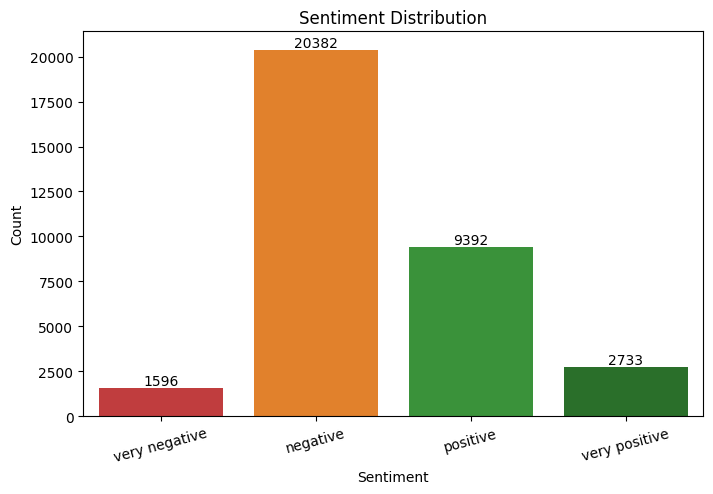

In [26]:
# Define the order and colors for sentiment labels
sentiment_order = ['very negative', 'negative', 'positive', 'very positive']
colors = ['#D62728', '#FF7F0E', '#2CA02C', '#1F7A1F']  # red, orange, green, dark green

# Count sentiment occurrences in your dataset
sentiment_counts = data['sentiment_label'].value_counts().reindex(sentiment_order, fill_value=0)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors)

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=15)

# Add subtitles for each label count
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v, str(v), ha='center', va='bottom')
    
plt.show()

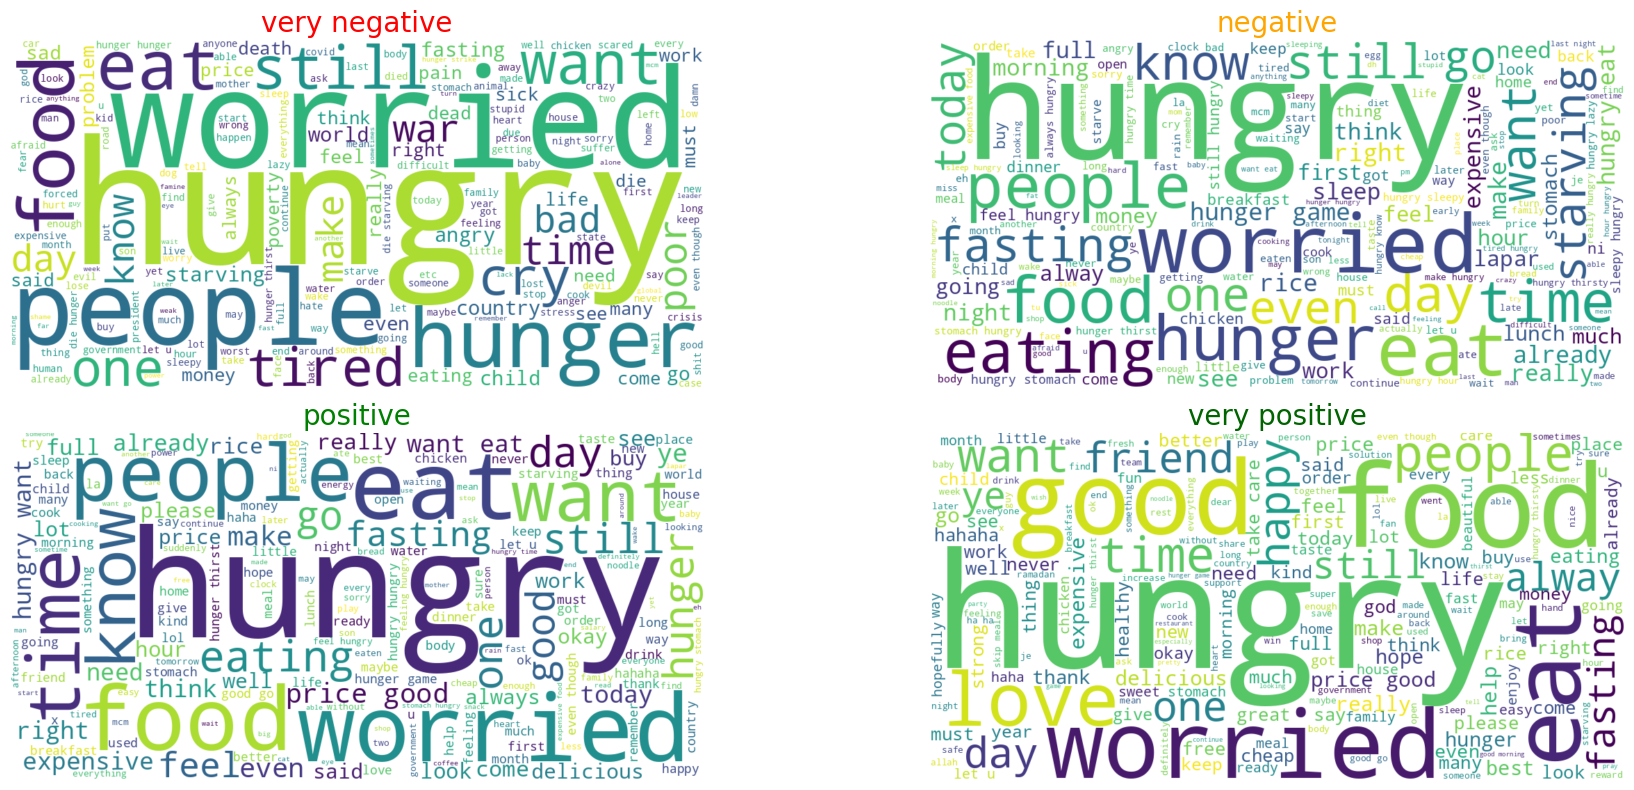

In [27]:
# Sentiment categories in order
sentiment_order = ['very negative', 'negative', 'positive', 'very positive']

# Define color mapping for sentiment labels
label_colors = {
    'very negative': 'red',
    'negative': 'orange',
    'positive': 'green',
    'very positive': 'darkgreen'
}

plt.figure(figsize=(20, 8))

for i, sentiment in enumerate(sentiment_order, 1):
    # Join all cleaned texts belonging to this sentiment
    text = ' '.join(data.loc[data['sentiment_label'] == sentiment, 'Cleaned_Text'])

    # Generate word cloud
    wc = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(text)

    # Plot subplot
    plt.subplot(2, 2, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(sentiment, fontsize=20, color=label_colors[sentiment])
    plt.axis('off')

plt.tight_layout()
plt.show()

## 🔥 Step 7: Risk Detection Based on Sentiment

In this step, we assess potential risk levels by leveraging the sentiment scores generated using VADER. The idea is that highly negative sentiment may indicate higher concern or distress related to food security. We assign risk levels based on the compound sentiment score:

* High Risk: Strongly negative sentiment (score ≤ -0.6)

* Medium Risk: Mildly negative to neutral sentiment (score between -0.6 and 0)

* Low Risk: Positive sentiment (score > 0)

This risk scoring helps to identify regions or users expressing greater concern, enabling targeted analysis of food security threats across different areas.

In [28]:
def assign_risk_score(sentiment_score):
    # Flip the sentiment polarity so that more negative sentiment = higher risk
    if sentiment_score <= -0.6:
        return 'High'
    elif sentiment_score <= 0:
        return 'Medium'
    else:
        return 'Low'

data['risk_level'] = data['sentiment_score'].apply(assign_risk_score)

In [29]:
data.head()

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label,risk_level
0,2022-02-01 00:18:19+00:00,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,negative,Medium
1,2022-02-01 00:20:14+00:00,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",NaN,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative,Medium
2,2022-02-01 01:04:00+00:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,negative,Medium
3,2022-02-01 01:06:14+00:00,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,negative,Medium
4,2022-02-01 01:20:36+00:00,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative,High


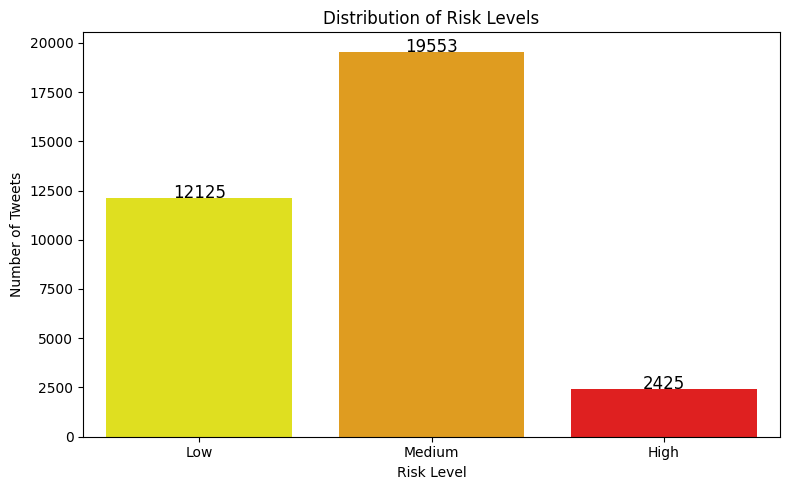

In [30]:
# Define the order and colors for risk levels
risk_order = ['Low', 'Medium', 'High']
risk_colors = ['yellow', 'orange', 'red']

plt.figure(figsize=(8,5))
ax = sns.countplot(data=data, x='risk_level', order=risk_order, palette=risk_colors)

# Add count numbers on top of the bars
for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 3,
            str(count), ha='center', fontsize=12)

plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()

## 📝 Step 8: Topic Modelling for Food Insecurity Using LDA

In this step, we applied **Latent Dirichlet Allocation (LDA)** to identify latent themes related to food insecurity in the tweet dataset. **LDA** is an **unsupervised topic modeling technique** that groups frequently co-occurring words into coherent topics. To determine the optimal number of topics, we trained multiple LDA models with **varying topic counts (from 2 to 10)**, evaluating each using **perplexity** and **coherence scores**. This approach helps balance both statistical fit and semantic interpretability.

The resulting **topics** reveal diverse dimensions of **food insecurity** discourse: **daily hunger struggles**, **emotional well-being**, **global hunger crisis**,**food access challenges**, and **food price inflation**. 

Each tweet was then assigned to the most probable topic to enable further analysis.

In [54]:
# Prepare the corpus
docs = data['Cleaned_Text'].dropna().tolist()

# Vectorize text into a document-term matrix
vectorizer = CountVectorizer(min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(docs)
feature_names = vectorizer.get_feature_names_out()

In [55]:
# Conversion for Gensim (Coherence)
tokenized_docs = [doc.split() for doc in docs]
dictionary = Dictionary(tokenized_docs)
corpus_gensim = [dictionary.doc2bow(text) for text in tokenized_docs]

In [56]:
# Range of topics to test
topic_range = range(2, 11) #from 2 to 10 topics

# Storage of results
perplexities = []
coherences = []

for n_topics in topic_range:
    lda_model = LatentDirichletAllocation(n_components=n_topics,
                                          max_iter=15,
                                          learning_method='batch',
                                          random_state=0)
    lda_model.fit(dtm)

    # Perplexity
    perplexity = lda_model.perplexity(dtm)
    perplexities.append(perplexity)

    # Coherence (gensim)
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[-10:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
    
    coherence_model = CoherenceModel(topics=topics,
                                     texts=tokenized_docs,
                                     dictionary=dictionary,
                                     coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherences.append(coherence_score)

    print(f"Topics: {n_topics} | Perplexity: {perplexity:.2f} | Coherence: {coherence_score:.4f}")

Topics: 2 | Perplexity: 1911.22 | Coherence: 0.3995
Topics: 3 | Perplexity: 1947.57 | Coherence: 0.4270
Topics: 4 | Perplexity: 2007.26 | Coherence: 0.4528
Topics: 5 | Perplexity: 2101.74 | Coherence: 0.4784
Topics: 6 | Perplexity: 2191.98 | Coherence: 0.4387
Topics: 7 | Perplexity: 2231.40 | Coherence: 0.4607
Topics: 8 | Perplexity: 2272.92 | Coherence: 0.4757
Topics: 9 | Perplexity: 2290.25 | Coherence: 0.5072
Topics: 10 | Perplexity: 2304.35 | Coherence: 0.5152


In [60]:
# Find the best number of topics
best_n_topics_perplexity = topic_range[np.argmin(perplexities)]
best_n_topics_coherence = topic_range[np.argmax(coherences)]

print(f"Best number of topics based on Perplexity: {best_n_topics_perplexity}")
print(f"Best number of topics based on Coherence Score: {best_n_topics_coherence}")

Best number of topics based on Perplexity: 2
Best number of topics based on Coherence Score: 10


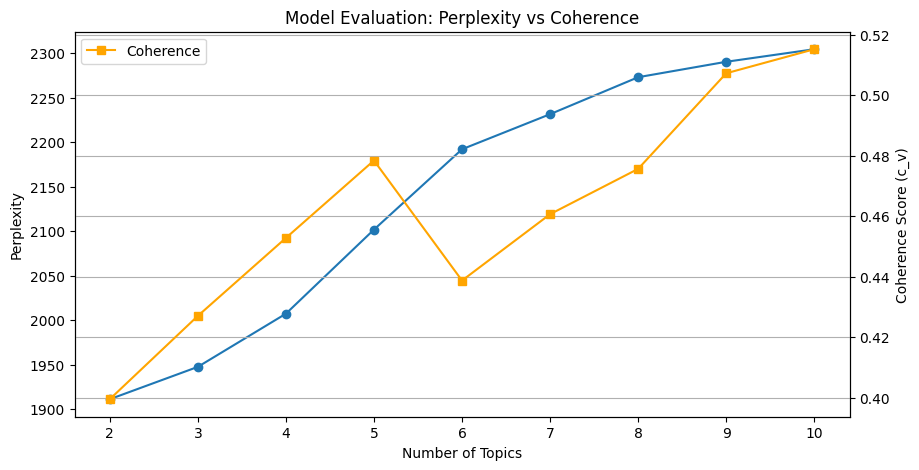

In [126]:
# Display of curves
plt.figure(figsize=(10,5))
plt.plot(topic_range, perplexities, label='Perplexity', marker='o')
plt.ylabel('Perplexity')
plt.xlabel('Number of Topics')
plt.twinx()
plt.plot(topic_range, coherences, label='Coherence', color='orange', marker='s')
plt.ylabel('Coherence Score (c_v)')
plt.title("Model Evaluation: Perplexity vs Coherence")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

After evaluating both **Perplexity** and **Coherence Score**, we found that:

* 2 topics give the lowest perplexity (better generalization)
* 10 topics give the highest coherence (better interpretability)

However, 5 topics offer a balanced trade-off between coherence and perplexity, making it a solid and interpretable choice for this dataset. 

In [70]:
# Fit LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics,
                                max_iter=20,
                                learning_method='batch',
                                random_state=0)
lda.fit(dtm)

LatentDirichletAllocation(max_iter=20, n_components=5, random_state=0)

In [72]:
# Display the top words per topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        print(f"🔹 Topic #{topic_idx+1}: " + ", ".join(top_words)+"\n")

feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, feature_names, n_top_words=25)

🔹 Topic #1: hungry, eat, fasting, hunger, rice, eating, day, time, morning, thirst, sleepy, like, want, tired, hold, thirsty, fast, holding, feel, really, chicken, today, fried, sleep, month

🔹 Topic #2: worried, like, time, love, know, really, make, think, going, feel, got, care, hope, day, friend, want, happy, right, na, thing, look, life, need, thank, baby

🔹 Topic #3: hunger, people, starving, food, game, world, help, poor, child, country, need, power, allah, god, money, human, starve, like, life, said, let, assistance, die, make, day

🔹 Topic #4: hungry, eat, want, stomach, food, time, night, hour, eating, like, la, lazy, lapar, order, know, cook, feel, rain, ni, hahaha, make, je, lunch, sleep, son

🔹 Topic #5: food, price, good, expensive, buy, rise, cheap, people, money, want, like, house, rising, increase, know, cat, time, year, stay, chicken, salary, thing, dog, cost, item



In [73]:
# Get topic distributions for each document (tweet)
topic_distributions = lda.transform(dtm)

# Assign each tweet to the topic with the highest probability
assigned_topics = np.argmax(topic_distributions, axis=1)

topic_names = {
    0: "Daily Hunger Struggles",
    1: "Emotional Well-being",
    2: "Global Hunger Crisis",
    3: "Food Access Challenges",
    4: "Food Price Inflation"
}

In [74]:
# Create a new column in your DataFrame for assigned topic
data['assigned_topic'] = [topic_names[i] for i in assigned_topics]

In [76]:
# Count tweets per topic
topic_counts = data['assigned_topic'].value_counts()
print("Number of tweets per topic:")
print(topic_counts)

Number of tweets per topic:
assigned_topic
Food Access Challenges    12153
Daily Hunger Struggles     7772
Emotional Well-being       5919
Global Hunger Crisis       4548
Food Price Inflation       3711
Name: count, dtype: int64


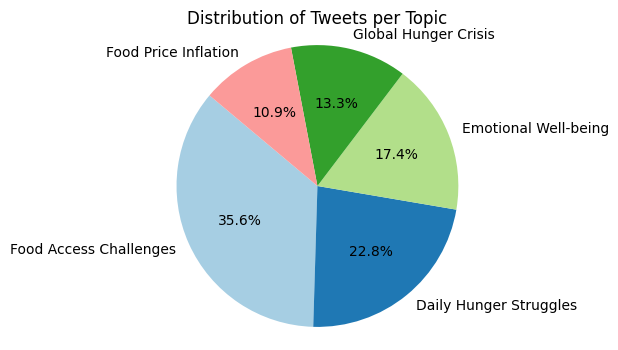

In [91]:
plt.figure(figsize=(4, 4))
plt.pie(topic_counts, labels=topic_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Tweets per Topic')
plt.axis('equal')
plt.show()

In [79]:
data.head()

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label,risk_level,assigned_topic
0,2022-02-01 00:18:19+00:00,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,negative,Medium,Global Hunger Crisis
1,2022-02-01 00:20:14+00:00,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",NaN,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative,Medium,Daily Hunger Struggles
2,2022-02-01 01:04:00+00:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,negative,Medium,Food Access Challenges
3,2022-02-01 01:06:14+00:00,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,negative,Medium,Daily Hunger Struggles
4,2022-02-01 01:20:36+00:00,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative,High,Daily Hunger Struggles


/tmp/ipykernel_35/572135890.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_topic_counts = data.groupby([data['Datetime'].dt.to_period('M'), 'assigned_topic']).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

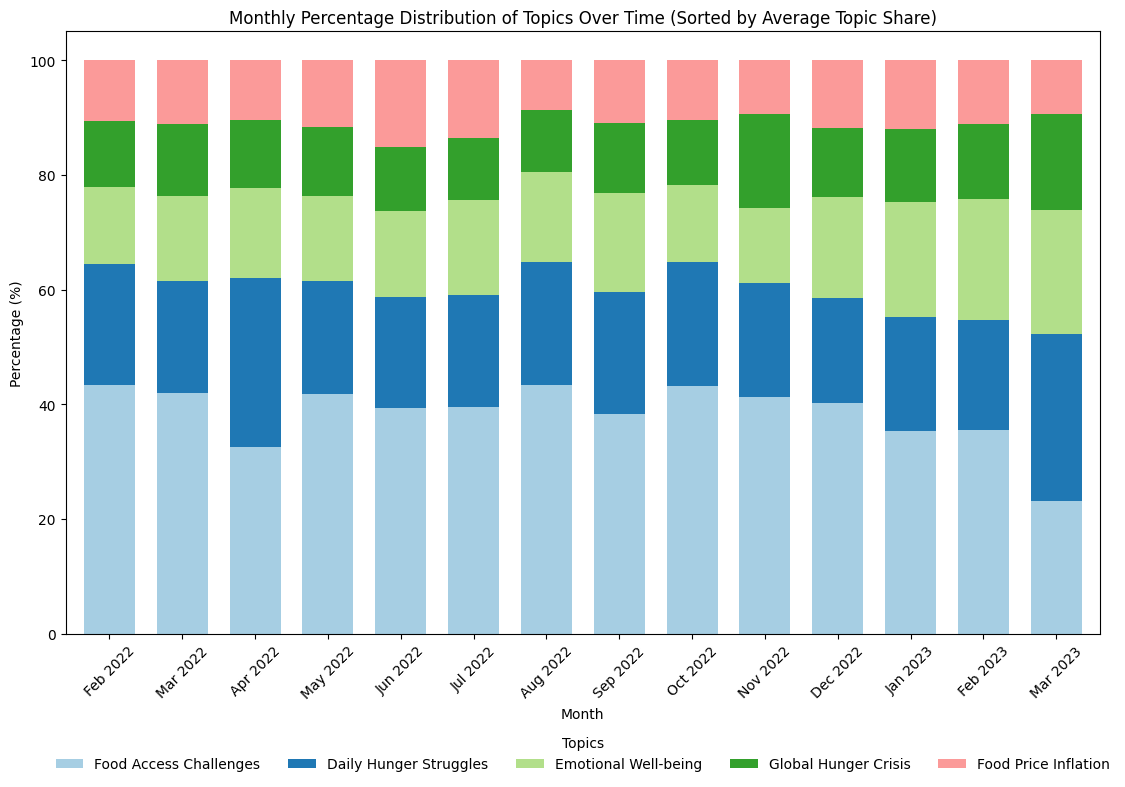

In [97]:
# Ensure Datetime is datetime type 
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Group by month and topic, count tweets
monthly_topic_counts = data.groupby([data['Datetime'].dt.to_period('M'), 'assigned_topic']).size().unstack(fill_value=0)

# Calculate percentage distribution per month
monthly_topic_percent = monthly_topic_counts.div(monthly_topic_counts.sum(axis=1), axis=0) * 100

# Sort topics by average percentage across all months (descending)
mean_topic_percent = monthly_topic_percent.mean().sort_values(ascending=False)
monthly_topic_percent_sorted = monthly_topic_percent[mean_topic_percent.index]

# Convert PeriodIndex to Timestamp for plotting
monthly_topic_percent_sorted.index = monthly_topic_percent_sorted.index.to_timestamp()

# Plot stacked bar chart with sorted topics
plt.figure(figsize=(12, 8))
monthly_topic_percent_sorted.plot(kind='bar', stacked=True, color=plt.cm.Paired.colors, width=0.7, figsize=(12, 8))

plt.title('Monthly Percentage Distribution of Topics Over Time (Sorted by Average Topic Share)')
plt.xlabel('Month')
plt.ylabel('Percentage (%)')
plt.legend(title='Topics', loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=5, frameon=False)
plt.xticks(rotation=45)

# Show all months on x-axis
plt.gca().set_xticks(range(len(monthly_topic_percent_sorted.index)))
plt.gca().set_xticklabels([d.strftime('%b %Y') for d in monthly_topic_percent_sorted.index])

plt.tight_layout()
plt.show()

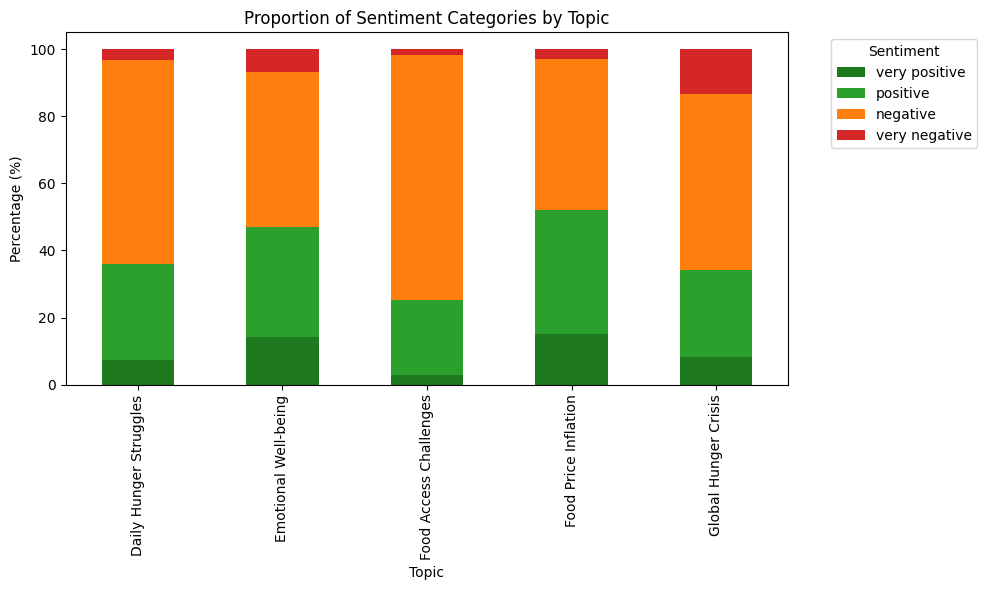

In [115]:
color_map = {
    'very positive': '#1F7A1F',  # dark green
    'positive': '#2CA02C',       # light green
    'negative': '#FF7F0E',       # light red
    'very negative': '#D62728'   # dark red
}

desired_order = ['very positive', 'positive', 'negative' , 'very negative']

# Reindex the columns in the desired order
topic_sentiment_proportion = topic_sentiment_proportion.reindex(columns=desired_order)

# Then plot as before
topic_sentiment_proportion.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    color=[color_map.get(x, '#333333') for x in topic_sentiment_proportion.columns]
)

plt.title("Proportion of Sentiment Categories by Topic")
plt.xlabel("Topic")
plt.ylabel("Percentage (%)")
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 🌍 Step 9: Geospatial and Temporal Analysis

In this step, we analyze the **spatial and temporal patterns of food security**-related sentiments and topics across Malaysia. Geospatial analysis involves mapping sentiment risk levels and topic distributions by **location** to identify hotspots or regions facing greater food insecurity challenges. Temporal analysis tracks how these risk levels and thematic discussions evolve **over time**, such as monthly trends, allowing us to observe seasonal effects, emerging issues, or shifts in public concern. 

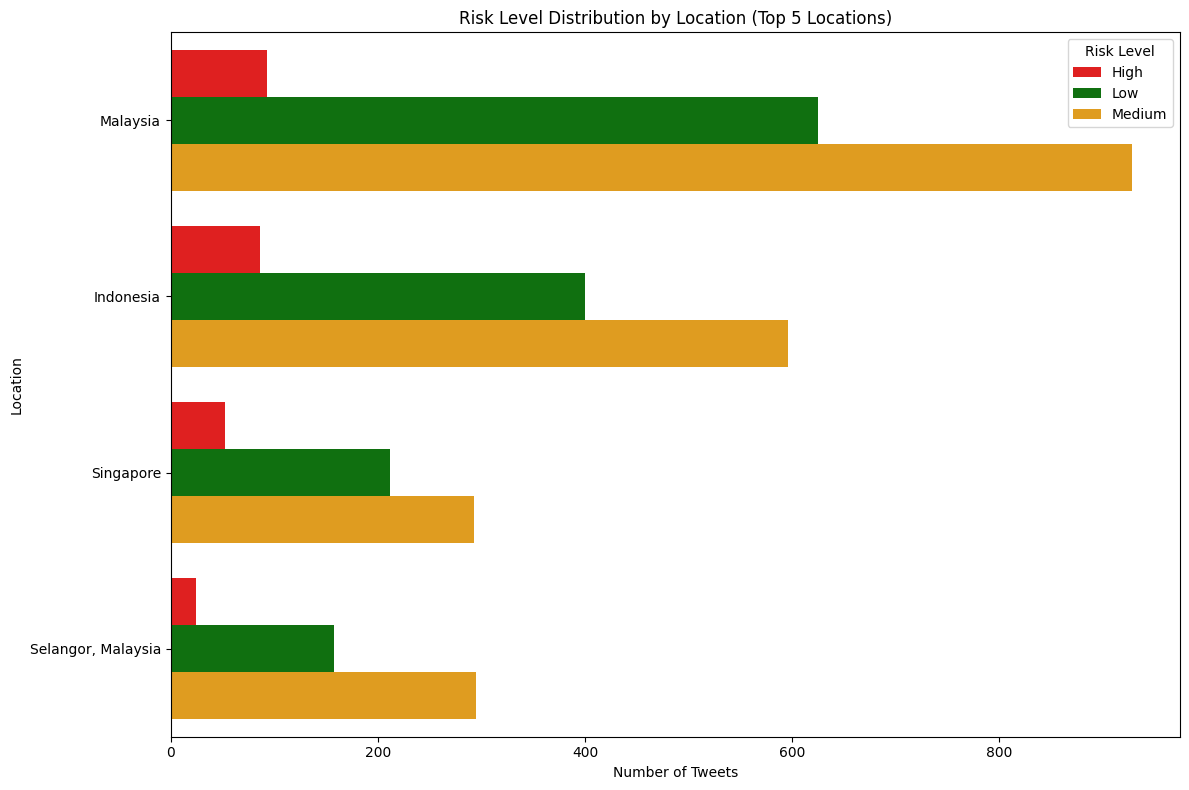

In [121]:
# Fill missing locations
data['Location'] = data['Location'].fillna('Unknown')

# Count the number of tweets per location
location_counts = data['Location'].value_counts().reset_index(name='count')
location_counts.columns = ['Location', 'count']

# Get the top 5 locations
top_5_locations = location_counts.head(5)['Location']

# Filter data to include only top 5 locations
top_5_data = data[data['Location'].isin(top_5_locations)]

# Count of risk levels per location (for top 5 locations only)
risk_counts = top_5_data.groupby(['Location', 'risk_level']).size().reset_index(name='count')

# Exclude 'Unknown' from the plot data, but not from the data itself
risk_counts = top_5_data[top_5_data['Location'] != 'Unknown'].groupby(['Location', 'risk_level']).size().reset_index(name='count')

# Sum the counts by location to sort the locations by total tweet count
location_order = risk_counts.groupby('Location')['count'].sum().sort_values(ascending=False).index

# Set color palette
risk_palette = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}

# Create the plot
plt.figure(figsize=(12, 8))
sns.barplot(data=risk_counts, 
            y='Location', 
            x='count', 
            hue='risk_level', 
            palette=risk_palette,
            order=location_order)  # Sort the locations by the total count

plt.title('Risk Level Distribution by Location (Top 5 Locations)')
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.legend(title='Risk Level')
plt.tight_layout()
plt.show()


This **horizontal bar chart displays** the distribution of tweets by **risk level** (🔴 High, 🟠 Medium, 🟢 Low) across the **top 5 most active locations**. 

📍 **Malaysia** has the **highest** number of tweets, with the majority being medium and low risk, reflecting a balanced sentiment. Similarly, **Indonesia** shows a large number of tweets, mostly in the medium category. **Singapore and Selangor** have **lower activity**, but still follow a similar risk distribution pattern. 

This visualization gives a clear picture of how risk perception and sentiment vary geographically 🌐.

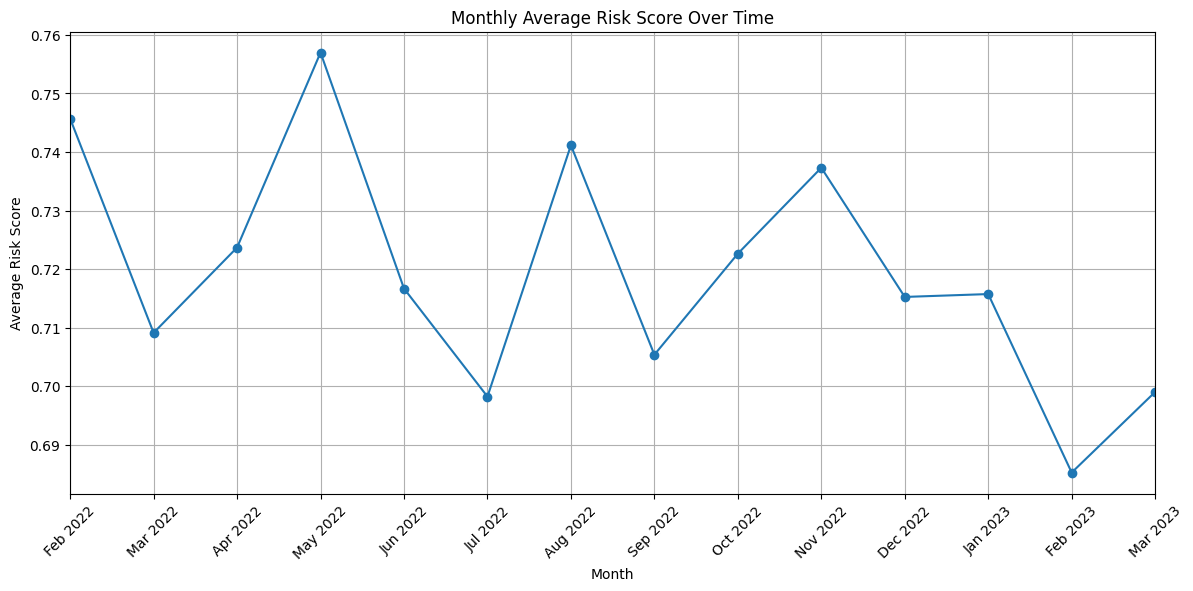

In [120]:
# Map risk levels to numeric scores temporarily for averaging
risk_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
data['risk_score'] = data['risk_level'].map(risk_mapping)

# Make sure datetime column is in datetime format
data['Datetime'] = pd.to_datetime(data['Datetime']).dt.tz_localize(None)

monthly_risk = data.groupby(data['Datetime'].dt.to_period('M'))['risk_score'].mean()

# Create full month range from min to max date in dataset
full_month_range = pd.period_range(start=data['Datetime'].min().to_period('M'),
                                  end=data['Datetime'].max().to_period('M'),
                                  freq='M')

# Reindex to full range, missing months will have NaN
monthly_risk = monthly_risk.reindex(full_month_range)


# Plot
plt.figure(figsize=(14, 6))
monthly_risk.index = monthly_risk.index.to_timestamp()  # Convert PeriodIndex to Timestamp for plotting
monthly_risk.plot(marker='o')
plt.title('Monthly Average Risk Score Over Time')
plt.xlabel('Month')
plt.ylabel('Average Risk Score')
plt.grid(True)

# Customize x-axis to show all months, formatted nicely
plt.xticks(monthly_risk.index, monthly_risk.index.strftime('%b %Y'), rotation=45)

plt.show()


### **Interpretation of Monthly Average Risk Score Trends in Malaysia (Feb 2022–Mar 2023)**


This line chart shows the trend of the **monthly average risk score in Malaysia** from **February 2022 to March 2023**. 📊 The risk score, which is based on sentiment polarity (where very negative sentiment indicates high risk), shows a slight **overall decreasing** trend over time. ⬇️

There are noticeable peaks in **May 2022** and **August 2022**, where the average risk score reached its highest values — indicating periods with a relatively **higher volume of negative sentiment** in tweets. 

In contrast, **February 2023** recorded the lowest average risk score, suggesting a **more positive public sentiment** during that time.

If we **compare** this with the first chart showing the **number of tweets**, we observe a **sudden spike** in tweet volume in **March 2023**, surpassing 1600 tweets in a day. 📈 However, this increase in activity **did not correspond** to a significant rise in the risk score, which remained relatively low. This may indicate that while more people were talking about the topic, the sentiment of these tweets was not particularly negative.

This analysis helps identify **critical periods** of public concern or **reassurance** over the year and shows that higher tweet volume doesn't always mean higher risk.

## 💾 Step 10: Save the Preprocessed Data and Pipeline

In [122]:
data.head(10)

,Datetime,Username,Text,Location,translated_Text,Cleaned_Text,sentiment_score,sentiment_label,risk_level,assigned_topic,risk_score
0,2022-02-01 00:18:19,HZMLRN,"I is lapar 🥲 (@ R&amp;R Perasing in Perasing, ...",Johor Bahru,"I is hungry 🥲 (@ r & r perception in action, t...",hungry r perception action terengganu,0.0000,negative,Medium,Global Hunger Crisis,1
1,2022-02-01 00:20:14,evaniaprilRS,"Suatu pagi-pagi buta di Siantar,\n\n🗣: aku lap...",Unknown,"One morning blind in Siantar,\n\n🗣: I'm hungry...",one morning blind siantar hungry want breakfas...,-0.3400,negative,Medium,Daily Hunger Struggles,1
2,2022-02-01 01:04:00,fahimzahar,Lapar... Angin dah .. sini pun jadi... (@ Tama...,Malaysia,Hungry ... the wind is already ...,hungry wind already,0.0000,negative,Medium,Food Access Challenges,1
3,2022-02-01 01:06:14,azlanowen,Dari jam 7 pagi sampe skrng jam 9 lewat msh mi...,"Kalimantan Timur, Indonesia",From 7 o'clock in the morning until now at 9 o...,clock morning clock thought breakfast breakfas...,0.0000,negative,Medium,Daily Hunger Struggles,1
4,2022-02-01 01:20:36,RazakZaha,Slowly rebuild pace.\n\nI got problem with kne...,Kuala Lumpur,Slowly rebuild pace.\n\nI got problem with kne...,slowly rebuild pace got problem knee injury su...,-0.8481,very negative,High,Daily Hunger Struggles,2
6,2022-02-01 01:32:54,RazakZaha,@ar_zaini3339 Slow tu.. Selalu masalah lapar t...,Kuala Lumpur,@ar_zaini3339 slow tu ... always a hunger prob...,slow tu always hunger problem tgh running,-0.5719,negative,Medium,Food Access Challenges,1
7,2022-02-01 02:54:44,teekayzamri,Lalalala lapar nasi (@ Restoran Sambal Hijau i...,Kuala Lumpur,Lalalala Hungry Rice (@ Green Sambal Restauran...,lalalala hungry rice green sambal restaurant k...,0.2500,positive,Low,Food Access Challenges,0
8,2022-02-01 03:33:33,KhaosodEnglish,(2/3) Suwanna said many fear the spill’s arriv...,"Bangkok, Thailand",(2/3) Suwanna said many fear the spill’s arriv...,suwanna said many fear spill arrival imminent ...,-0.4767,negative,Medium,Emotional Well-being,1
9,2022-02-01 03:56:07,StephaninBKK,@hizaga @703pippa Yes! When I go shopping hun...,Bangkok,@hizaga @703pippa Yes! When I go shopping hun...,yes go shopping hungry always get good snack,0.6808,positive,Low,Food Price Inflation,0
11,2022-02-01 04:11:09,cikgu_fadzli,"29 Januari 2022\nPasir Mas, Kelantan.\n\nMisi ...","Besut, Terengganu","January 29, 2022\nPasir Mas, Kelantan.\n\nThe ...",january pasir ma kelantan mission removing sta...,0.0000,negative,Medium,Global Hunger Crisis,1


In [127]:
# Save to CSV
data.to_csv('food_security_processed_data.csv', index=False)

In [128]:
# Save the pipeline to a file
joblib.dump(pipeline, 'text_preprocessor_pipeline.joblib')

['text_preprocessor_pipeline.joblib']

> **To Load the saved pipeline**
> 
> loaded_pipeline = joblib.load('text_preprocessor_pipeline.joblib')
> 
> text = "Food aid delays cause hunger! #hunger @aid"
> 
> cleaned_text = loaded_pipeline.transform(text)
>
* cleaned_text result : 'food aid delay hunger'

<center>In this notebook, we've successfully cleaned and preprocessed social media data, translated it to English, and prepared it for sentiment analysis. In the next step, we'll build a sentiment classification model to analyze opinions on food security in Malaysia.</center>